Export data we need using SQL:

``` mysql
WITH denver_data AS (
  SELECT year, city, avg_temp AS denver_temp
      FROM city_data
    WHERE city = 'Denver' AND avg_temp IS NOT NULL
  )
SELECT denver_data.year, denver_data.denver_temp, global_data.avg_temp FROM denver_data
JOIN global_data
ON denver_data.year = global_data.year;
```

Once saved as csv export, computer moving average in python with pandas

In [2]:

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# here is the SQL export with temp data
wd = '/Users/paultanger/Desktop/Dropbox/2020 data science stuff/data science course stuff/udacity data analyst nanodegree/'
tempdata = pd.read_csv(wd + 'combined_temps.csv')

window_size = 3 
tempdata['Denver_T_3yr_moving_avg'] = tempdata.loc[:,'denver_temp'].rolling(window=window_size).mean()
tempdata['Global_T_3yr_moving_avg'] = tempdata.loc[:,'avg_temp'].rolling(window=window_size).mean()

# convert to long format to plot together
tempdata_long = tempdata.melt(id_vars='year')
tempdata_long.head()
tempdata_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      784 non-null    int64  
 1   variable  784 non-null    object 
 2   value     780 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.5+ KB


Now let's plot it

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


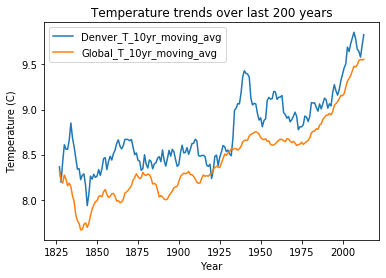

In [3]:
# ok just plot moving avgs
# also Denver doesn't have consistent data until 1820 so just start there
tempdata2 = tempdata.iloc[:, [0,3,4]]
tempdata_long2 = tempdata2.melt(id_vars='year')
tempdata_long2 = tempdata_long2[tempdata_long.year >= 1820]

# try with 10 yr avg
window_size = 10
tempdata['Denver_T_10yr_moving_avg'] = tempdata.loc[:,'denver_temp'].rolling(window=window_size).mean()
tempdata['Global_T_10yr_moving_avg'] = tempdata.loc[:,'avg_temp'].rolling(window=window_size).mean()

tempdata3 = tempdata.iloc[:, [0,5,6]]
tempdata_long3 = tempdata3.melt(id_vars='year')
tempdata_long3 = tempdata_long3[tempdata_long.year >= 1820]

lineplt3 = sns.lineplot(x='year', y='value', hue='variable', data=tempdata_long3)
# nice axis labels
lineplt3.set(xlabel='Year', ylabel='Temperature (C)')
lineplt3.set_title('Temperature trends over last 200 years')

# remove legend title
handles, labels = lineplt3.get_legend_handles_labels()
lineplt3.legend(handles=handles[1:], labels=labels[1:])

Seems like Denver overall is warmer.  Let's get the overall means.

In [8]:
print(tempdata.Denver_T_10yr_moving_avg.mean())
print(tempdata.Global_T_10yr_moving_avg.mean())

8.76147593582888
8.446978609625667


Maybe Denver is also a bit more variable - based on this data, I was wrong!

In [27]:
import numpy as np
from scipy.stats import variation

print(tempdata.Denver_T_10yr_moving_avg.std())
print(tempdata.Global_T_10yr_moving_avg.std())

print(variation(tempdata['Denver_T_10yr_moving_avg'], nan_policy = 'omit'))
print(variation(tempdata['Global_T_10yr_moving_avg'], nan_policy = 'omit'))

0.40551664008465027
0.4236589716637381
0.046160135633451366
0.05002080562998671


and check out scatterplot between means. Some variation here, not completely linear.

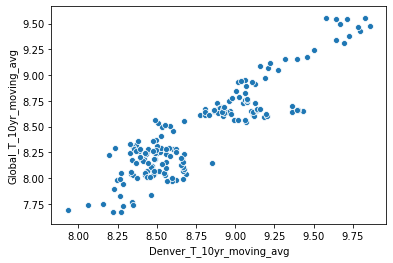

In [4]:
scatterplt = sns.scatterplot(x="Denver_T_10yr_moving_avg", y="Global_T_10yr_moving_avg", data=tempdata3)

Also, not quite normal data

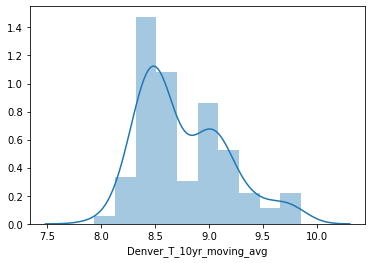

In [5]:
# not quite normal?
sns.distplot(tempdata3['Denver_T_10yr_moving_avg'])

So let's use Spearman's not Pearson's

In [6]:
tempdata3['Denver_T_10yr_moving_avg'].corr(tempdata3['Global_T_10yr_moving_avg'], method='spearman')

0.8280098730994742

What about predicting Denver temp based on regression of Global temps?
I used this as a guide for this section, super helpful!
https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

In [39]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# drop nas
tempdata3 = tempdata3.dropna(axis=0, how='any')
#print(tempdata3.head(100))

X = tempdata3['Global_T_10yr_moving_avg'].values.reshape(-1,1)
y = tempdata3['Denver_T_10yr_moving_avg'].values.reshape(-1,1)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
y_pred = regressor.predict(X_test)
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

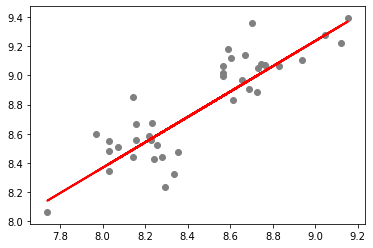

In [41]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [42]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1323157803733795
Mean Squared Error: 0.02892370864156341
Root Mean Squared Error: 0.17006971700324372


Four Observations regarding this data:

* Overall, the temperature of Denver is a bit higher than the global temperature
* Both demonstrate an overall trend of increasing temperatures
* There is a clear correlation between the temperatures (Spearman rho = 0.82)
* While it appears there is more variability in the Denver temps compared to global temps, the SD and coefficient of variation do not support this conclusion.